In [1]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

## Quora

In [9]:
quora_train, quora_test = pd.read_csv('quora/train.csv'), pd.read_csv('quora/test.csv')

quora_q1 = quora_train['question1'].tolist() + quora_test['question1'].tolist()
quora_q2 = quora_train['question2'].tolist() + quora_test['question2'].tolist()
quora = pd.DataFrame(data={'question1': quora_q1, 'question2': quora_q2})

In [13]:
quora_qs = pd.Series(quora['question1'].tolist() + quora['question2'].tolist()).astype(str)
quora_qs_length = quora_qs.apply(lambda x: len(x.split(' ')))

## ATEC

In [19]:
atec = pd.read_csv('ATEC/train.txt', 
                   index_col=0, 
                   header=None, 
                   names=['question1','question2','is_duplicate'],
                   sep='\t',
                   engine='python',
                   encoding='utf-8-sig')

In [22]:
atec_qs = pd.Series(atec['question1'].tolist() + atec['question2'].tolist()).astype(str)
atec_qs_length = atec_qs.apply(len)

In [29]:
print('Quora: Total number of question pairs is {}'.format(len(quora)))

print('\nATEC: Total number of question pairs is {}'.format(len(atec)))

Quora: Total number of question pairs is 2750086

ATEC: Total number of question pairs is 39346


Quora: mean 11.03 std 5.85 ATEC: mean 13.35 std 6.04


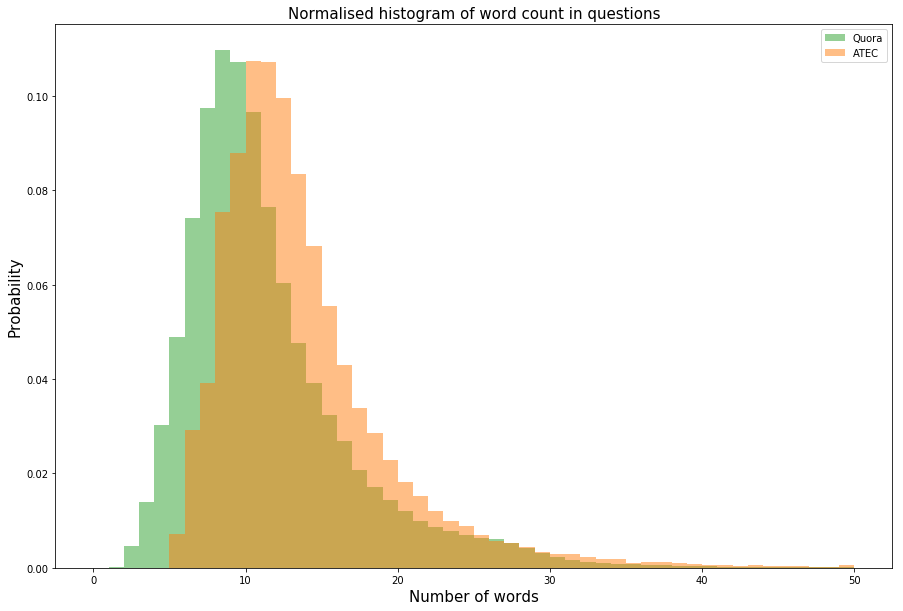

In [24]:
plt.figure(figsize=(15, 10))
plt.hist(quora_qs_length, bins=50, range=[0, 50], color=pal[2], density=True, alpha=0.5, label='Quora')
plt.hist(atec_qs_length, bins=50, range=[0, 50], color=pal[1], density=True, alpha=0.5, label='ATEC')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Quora: mean {:.2f} std {:.2f} ATEC: mean {:.2f} std {:.2f}'.format(quora_qs_length.mean(), quora_qs_length.std(), atec_qs_length.mean(), atec_qs_length.std()))

In [31]:
### train test split for ATEC
from sklearn.model_selection import train_test_split

atec_train, atec_test = train_test_split(atec, test_size=0.2, random_state=42)

In [37]:
print('Quora: Duplicate question pairs rate is {}'.format(atec_train['is_duplicate'].sum() / len(atec_train)))

print('\nATEC: Duplicate question pairs rate is {}'.format(quora_train['is_duplicate'].sum() / len(quora_train)))

Quora: Duplicate question pairs rate is 0.21680010166476046

ATEC: Duplicate question pairs rate is 0.369197853026293


In [66]:
### Initial Feature Analysis
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share_en(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

Text(0.5, 0, 'word_match_share')

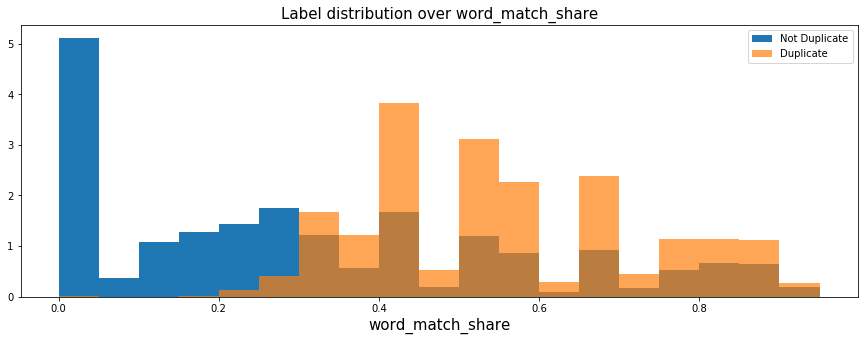

In [67]:
# For Quora dataset
plt.figure(figsize=(15, 5))
quora_word_share = quora_train.apply(word_match_share_en, axis=1, raw=True)
plt.hist(quora_word_share[quora_train['is_duplicate'] == 0], np.arange(0,1,0.05), density=True, label='Not Duplicate')
plt.hist(quora_word_share[quora_train['is_duplicate'] == 1], np.arange(0,1,0.05), density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [94]:
stops = set([w.strip() for w in open('ATEC/stopwords.txt','r').readlines()])

def word_match_share_cn(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']):
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']):
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

Text(0.5, 0, 'word_match_share')

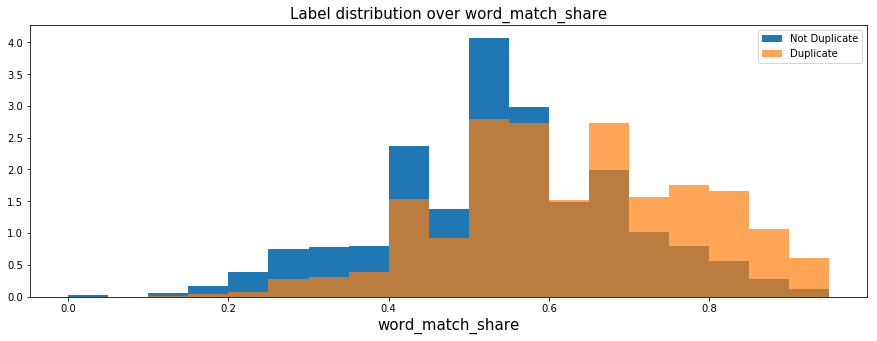

In [95]:
# For ATEC dataset
plt.figure(figsize=(15, 5))
atec_word_share = atec_train.apply(word_match_share_cn, axis=1, raw=True)
plt.hist(atec_word_share[atec_train['is_duplicate'] == 0], bins=np.arange(0,1,0.05), density=True, label='Not Duplicate')
plt.hist(atec_word_share[atec_train['is_duplicate'] == 1], bins=np.arange(0,1,0.05), density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)